In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

## Prep animal meta data

In [45]:
path_meta = '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/VP3.csv'

data_meta = pd.read_csv(path_meta)
data_meta = pd.DataFrame(data = data_meta)

#get time diff in seconds
data_meta['start_VP'] = pd.to_datetime(data_meta['Time_VP']) - pd.to_datetime(data_meta['Time_FP']) 
data_meta['start_VP']=data_meta['start_VP']/np.timedelta64(1,'s') 

print(data_meta.shape)
data_meta.head()

(12, 5)


,Animal,Group,Time_FP,Time_VP,start_VP
0,1153,1,11:19:42,11:25:09,327.0
1,1154,1,12:01:01,12:06:35,334.0
2,1155,2,10:42:36,10:48:12,336.0
3,1157,2,12:21:03,12:26:28,325.0
4,1158,2,1:48:50,1:54:34,344.0


## Prep Med data

### Variable Definitions

- E   = event identity stamp
- T   = event time stamp

### Event Stamps ( array E )

- 5   = Pellet reinforcement delivery
- 6   = Food tray head entry
- 100 = Session termination
- 15  = ITI starts
- 16  = ITI ends

In [46]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    session = int(file_path_name.split('/')[-1].split('_')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, session, animal, date

In [47]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [48]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(str(event_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        if re.search(str(time_letter + ':'), str(array[i])):
            i = i + 1
            try:
                while re.search('\[\'\ \ ', str(array[i])):
                    split = array[i][0].split()[1:]
                    for element in split:
                        time_data.append(float(element))
                    i = i + 1
            except:
                pass
        i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [49]:
def get_trial_times_VP(events_and_times, ITI_end, session_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for pellet deliveries and end of trial segment
    #finds time_stamps for each start and end, puts into new dataframe

    ITI_end = list(events_and_times[events_and_times['event_stamp'] == ITI_end]['time_stamp'].values)
    session_end = list(events_and_times[events_and_times['event_stamp'] == session_end]['time_stamp'].values)
    
    start_times = ITI_end
    end_times = np.append(ITI_end[1:], session_end)

    times = pd.DataFrame(data = [start_times, end_times])
    times = times.T
    times.columns = ['trial_start', 'trial_end']
    
    return times

In [50]:
def create_trial_df(events_and_times, trial_times):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    while i < len(trial_times):
        data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i] - .01)]
        data['trial_#'] = [i]*len(data)
        data['trial_start'] = trial_times['trial_start'][i]
        data['trial_end'] = trial_times['trial_end'][i]
        trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
        i = i + 1
    
    return trial_data

In [51]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [52]:
def latency(trial_data, event_num):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
        else:
            latency_1st.append((data['time_stamp'] - data['trial_start']).values[0])
        i = i + 1
    
    return latency_1st

In [53]:
def create_session_df(trial_data, event_dic):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
    times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')] = latency(trial_data, event)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    session_data['trial_start'] = trial_data.groupby('trial_#')['trial_start'].first()
    session_data['first_pellet'] = trial_data[trial_data['event_stamp'] == 5.0].groupby('trial_#')['time_stamp'].first()
    session_data['first_HE'] = trial_data[trial_data['event_stamp'] == 6.0].groupby('trial_#')['time_stamp'].first()
    
    return session_data

### Get med file paths

In [54]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

12
12


'/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1166_210212'

### Process Med data

In [55]:
%%time
final_data = pd.DataFrame()

bit_dic = {'HE': 6, 'pellet': 5}

for file in file_paths:

    print(file) 
    
    #proccess file
    task, session, animal, date = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E", "T")
    trial_times = get_trial_times_VP(events_and_times, 16, 100)
    trial_data = create_trial_df(events_and_times, trial_times)
    session_data = create_session_df(trial_data, bit_dic)
   
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])    
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['Animal'] = [animal]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['group'] = int(data_meta[data_meta['Animal'] == int(animal)]['Group'])
   
    session_data = session_data[['task', 'date', 'session', 'Animal', 'group', 'trial_num', 
                                 'trial_duration', 'trial_start', 'first_pellet', 'first_HE',
                                 'HE_count', 'HE_latency_1st', 'pellet_count']]
    
    #add to final data frame
    final_data = pd.concat([final_data, session_data], axis = 0, ignore_index=True)

final_data.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1166_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1154_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1158_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1162_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1160_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1153_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1165_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1163_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1155_210212
/Users/abbieschindler/Docume

,task,date,session,Animal,group,trial_num,trial_duration,trial_start,first_pellet,first_HE,HE_count,HE_latency_1st,pellet_count
0,VP,210212,3,1166,2,0,30.2,89.99,90.0,114.28,2,24.29,1
1,VP,210212,3,1166,2,1,60.9,120.19,120.2,126.29,11,6.10,2
2,VP,210212,3,1166,2,2,32.3,181.09,181.1,191.52,4,10.43,4
3,VP,210212,3,1166,2,3,62.3,213.39,213.4,216.10,12,2.71,4
4,VP,210212,3,1166,2,4,90.9,275.69,275.7,281.54,9,5.85,2


### Merge with meta data and adjust times based on info in meta data

In [56]:
data_final = final_data.merge(data_meta, on='Animal')
data_final['trial_start'] = data_final['trial_start'] + data_final['start_VP'] -1
data_final['first_pellet'] = data_final['first_pellet'] + data_final['start_VP'] -1
data_final['first_HE'] = data_final['first_HE'] + data_final['start_VP'] -1

#drop final trial (no pellet delivered)
data_final = data_final[data_final['trial_num'] != 9]
print(data_final.shape)
data_final.head()

(108, 17)


,task,date,session,Animal,group,trial_num,trial_duration,trial_start,first_pellet,first_HE,HE_count,HE_latency_1st,pellet_count,Group,Time_FP,Time_VP,start_VP
0,VP,210212,3,1166,2,0,30.2,428.99,429.0,453.28,2,24.29,1,2,2:25:10,2:30:50,340.0
1,VP,210212,3,1166,2,1,60.9,459.19,459.2,465.29,11,6.10,2,2,2:25:10,2:30:50,340.0
2,VP,210212,3,1166,2,2,32.3,520.09,520.1,530.52,4,10.43,4,2,2:25:10,2:30:50,340.0
3,VP,210212,3,1166,2,3,62.3,552.39,552.4,555.10,12,2.71,4,2,2:25:10,2:30:50,340.0
4,VP,210212,3,1166,2,4,90.9,614.69,614.7,620.54,9,5.85,2,2,2:25:10,2:30:50,340.0


In [137]:
data_final_long = pd.melt(data_final, id_vars=['task', 'date', 'session', 'Animal', 'group', 'trial_num', 'trial_duration',
                            'HE_count', 'HE_latency_1st', 'pellet_count'], 
        value_vars=['trial_start', 'first_pellet', 'first_HE',],
        var_name='event', value_name='time')

print(data_final_long.shape)
data_final_long.head(1)

(324, 12)


,task,date,session,Animal,group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event,time
0,VP,210212,3,1166,2,0,30.2,2,24.29,1,trial_start,428.99


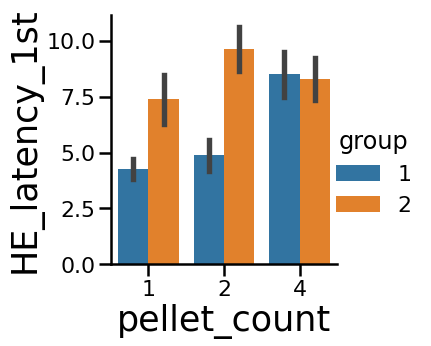

In [147]:
sns.catplot(x='pellet_count', y='HE_latency_1st', data=data_final_long, ci=68, hue='group', kind='bar')

## Prep FP data

### Get FP file paths

In [16]:
#create list of dir paths

orig_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212'

dir_path_list = os.listdir(orig_path)

data_dir_paths = []
for directory in dir_path_list:
    int_path = orig_path + '/' + directory
    data_dir_paths.append(int_path)
    
data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1166_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1159_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1158_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1165_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1153_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1161_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1157_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1160_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1154_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1162_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1163_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1155_VP2.txt']

### Process FP data

In [17]:
def create_FP_df(path):
    
    data_FP = pd.DataFrame()
        
    animal = int(path.split('/')[-1].split('_')[0])
    task = path.split('/')[-1].split('_')[1].split('.')[0]
    
    with open(path, 'r') as file:
        lns = file.readlines()
    
    for ln in lns:
        time = float(ln.split('\t')[0])
        signal = float(ln.split('\t')[1])  
        d = {'Animal': animal, 'task': task, 'time': [time], 'signal': [signal]}
        data_FP_int = pd.DataFrame(data=d)
        
        if data_FP.shape[0] == 0:
            data_FP = data_FP_int
        else:
            data_FP = pd.concat([data_FP, data_FP_int], axis=0)
    
    data_FP = data_FP.reset_index()
    
    return data_FP
        

In [18]:
FP_df = pd.DataFrame()

for path in data_dir_paths:
    print(path)
    
    data_int = create_FP_df(path)

    if FP_df.shape[0] == 0:
        FP_df = data_int
    else:
        FP_df = pd.concat([FP_df, data_int], axis=0)

/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1166_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1159_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1158_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1165_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1153_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1161_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1157_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1160_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1154_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1162_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1163_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210212/1155_VP2.txt


## Combine data streams

In [59]:
data_final_long.head()

,task,date,session,Animal,group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event,time
0,VP,210212,3,1166,2,0,30.2,2,24.29,1,trial_start,428.99
1,VP,210212,3,1166,2,1,60.9,11,6.10,2,trial_start,459.19
2,VP,210212,3,1166,2,2,32.3,4,10.43,4,trial_start,520.09
3,VP,210212,3,1166,2,3,62.3,12,2.71,4,trial_start,552.39
4,VP,210212,3,1166,2,4,90.9,9,5.85,2,trial_start,614.69


In [32]:
FP_df.groupby('Animal')['time'].max()

Animal
1153     929.59
1154     928.96
1155     907.94
1157     947.45
1158     912.49
1159    1170.47
1160     878.91
1161     949.88
1162     934.96
1163     979.85
1165    1293.84
1166     932.37
Name: time, dtype: float64

In [60]:
data_final.groupby('Animal')['trial_start'].max()

Animal
1153     875.99
1154     882.29
1155     884.99
1157     873.29
1158     892.29
1159    1160.89
1160     889.29
1161     922.29
1162     881.29
1163     906.29
1165     872.89
1166     888.29
Name: trial_start, dtype: float64

In [61]:
data_comb = FP_df.merge(data_final_long, on=['Animal', 'time'], how='left')
print(data_comb.shape)
data_comb.tail()

(1176683, 15)


,index,Animal,task_x,time,signal,task_y,date,session,group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event
1176678,0,1155,VP2,907.90,32575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176679,0,1155,VP2,907.91,32576.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176680,0,1155,VP2,907.92,32577.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176681,0,1155,VP2,907.93,32582.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176682,0,1155,VP2,907.94,32577.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get perievent

In [170]:
def peri_event(df, time, total_time, baseline_time):
    
    #time = time when event happens
    #total_time = total length of peri event
    #baseline_time = baseline duration (assumed that this should be taken from immediately prior to the event)
    
    start_time = time - baseline_time
    end_time = start_time + total_time

    #get peri event signal
    data_int = df[(df['time'] >= start_time) & (df['time'] <= (end_time))]
    data_int['event_time'] = data_int.reset_index().index / 100
    
    #get baseline signal and compute median and MAD
    baseline_signal = df[(df['time'] >= start_time) & (df['time'] < (time))]['signal']
    f_med = baseline_signal.median()
    f_mad = baseline_signal.mad()

    #compute robust z score 
    data_int['sig_z'] = (data_int['signal'] - f_med) / (f_mad)
    
    return data_int

In [183]:
def robustz_df(df, event):
    
    times = df[~df['event'].isna()]['time'].values
    
    data_final_int = pd.DataFrame()

    for time in times:
        data_int = peri_event(df, time, 15, 5)
        data_int['pellet'] = int(df[df['time'] == time]['pellet_count'])
        data_int['group'] = int(df[df['time'] == time]['group'])
    
        if data_final_int.shape[0] == 0:
            data_final_int = data_int
        else:
            data_final_int = pd.concat([data_final_int, data_int], axis=0)

    return data_final_int

In [184]:
perievent_df = pd.DataFrame()

for animal in data_comb['Animal'].unique():
    print(animal)
    df_int = data_comb[data_comb['Animal'] == animal]
    data_final_int = robustz_df(df_int, 'first_pellet')
    
    if perievent_df.shape[0] == 0:
        perievent_df = data_final_int
    else:
        perievent_df = pd.concat([perievent_df, data_final_int], axis=0)
        
    print(perievent_df.shape)
    
perievent_df.head()

1166
(37525, 18)
1159
(70504, 18)
1158
(102831, 18)
1165
(140356, 18)
1153
(176380, 18)
1161
(212404, 18)
1157
(248428, 18)
1160
(281450, 18)
1154
(309967, 18)
1162
(345991, 18)
1163
(382015, 18)
1155
(416538, 18)


,index,Animal,task_x,time,signal,task_y,date,session,group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event,event_time,sig_z,pellet
42399,0,1166,VP2,423.99,33294.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,-2.636954,1
42400,0,1166,VP2,424.00,33296.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.01,-2.599550,1
42401,0,1166,VP2,424.01,33298.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.02,-2.562147,1
42402,0,1166,VP2,424.02,33299.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.03,-2.543445,1
42403,0,1166,VP2,424.03,33293.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.04,-2.655656,1


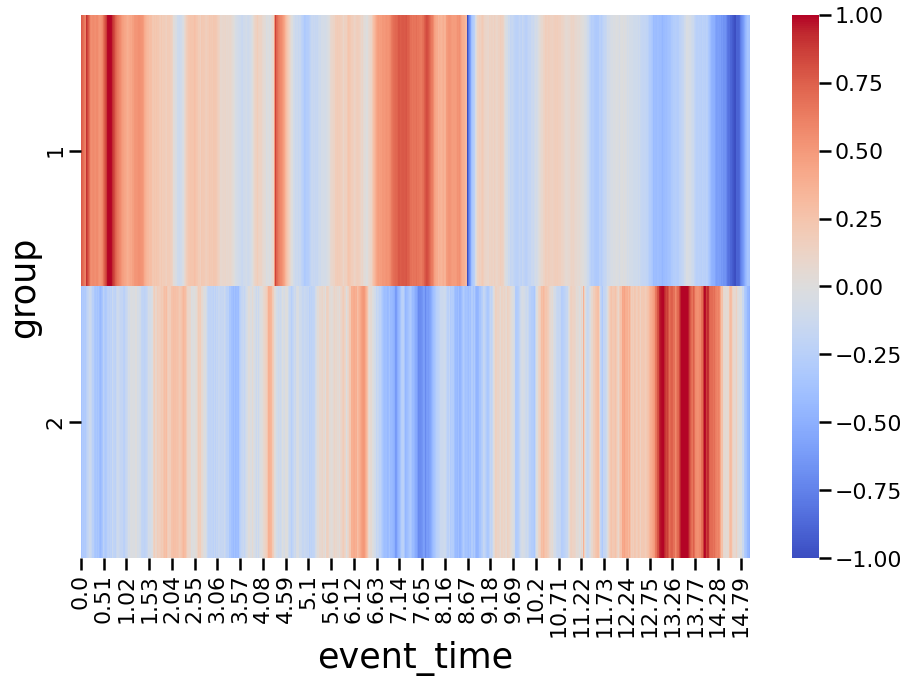

In [185]:
d = perievent_df[perievent_df['pellet'] == 4]
animals_exclude = [1155, 1154]
d=d[~d['Animal'].isin(animals_exclude)]
#d = d[d['group'] == 2]
groupby = d.groupby(['group', 'event_time'])['sig_z'].mean().reset_index()
#viz
groupby = groupby.pivot('group', 'event_time', "sig_z")
plt.figure(figsize=(15,10))
ax = sns.heatmap(groupby, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

<AxesSubplot:xlabel='event_time', ylabel='sig_z'>

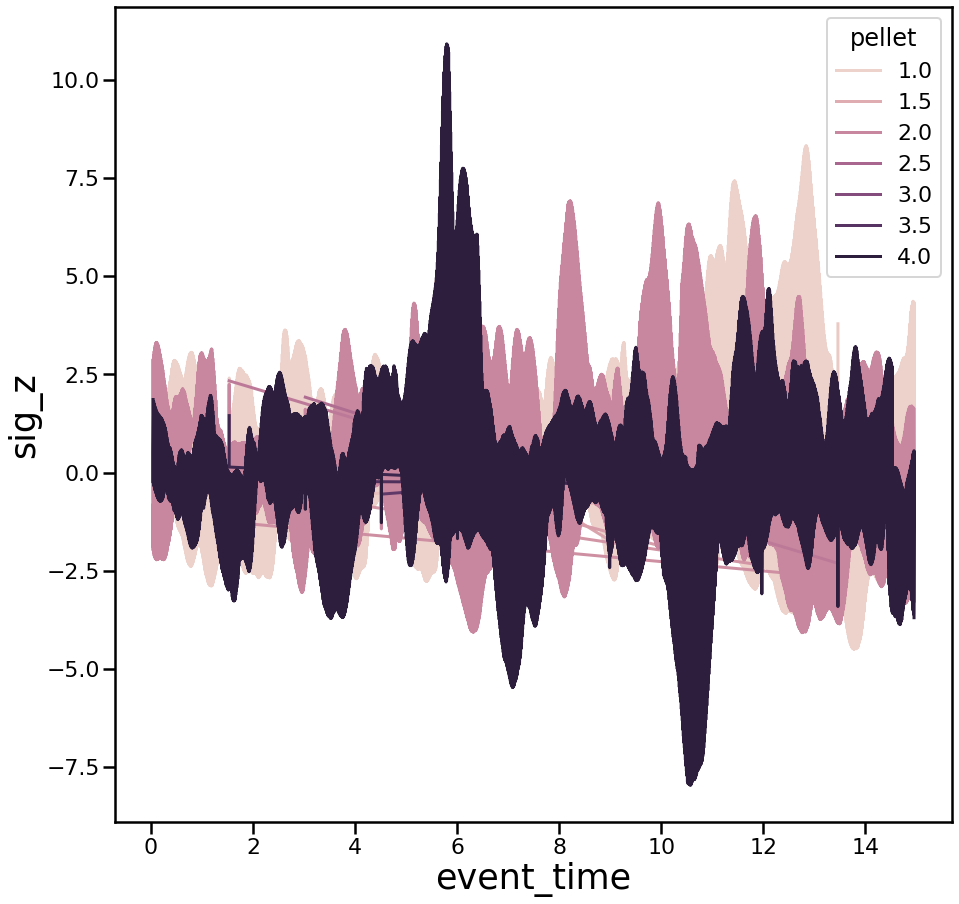

In [111]:
plt.figure(figsize=(15,15))
d = perievent_df[perievent_df['pellet'] == 4].rolling(10).mean()
sns.lineplot(x='event_time', y='sig_z', data=d, ci=68, hue='pellet')

In [ ]:
plt.figure(figsize=(15,15))
data=perievent_df[perievent_df['Animal'] != 1155]
data=data[data['Animal'] != 1154]
sns.lineplot(x='event_time', y='sig_z', data=data, ci=68, hue='Group', size='pellet')

1166


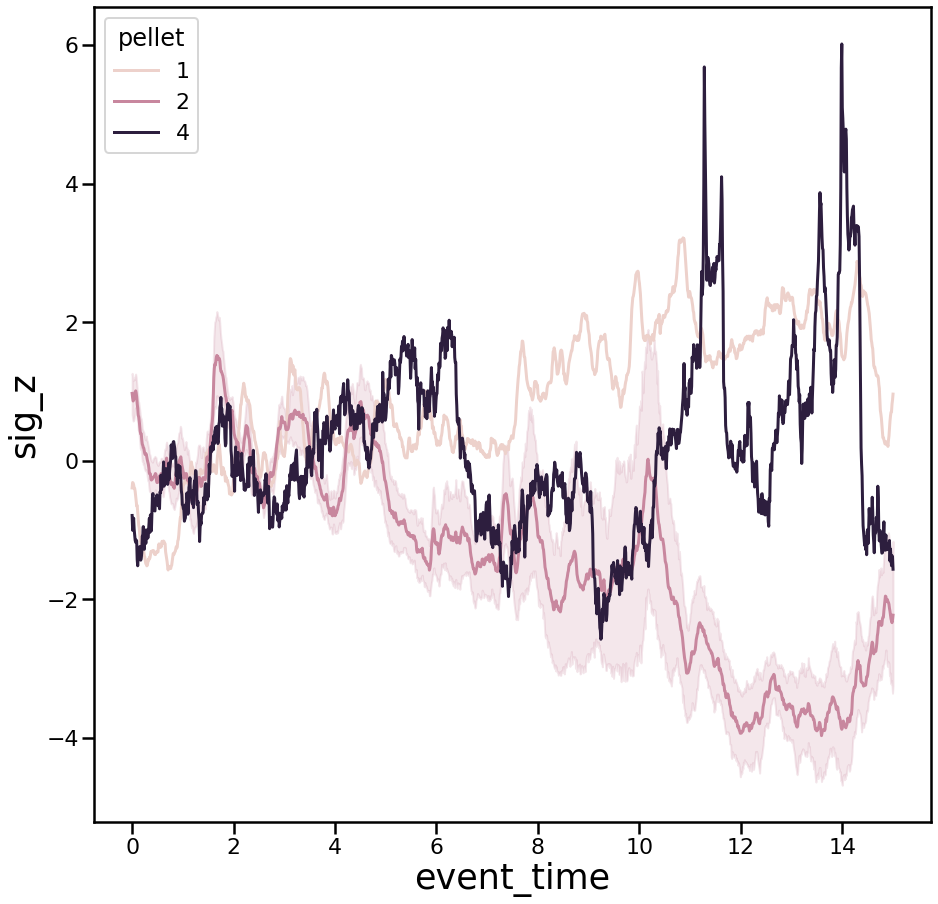

1159


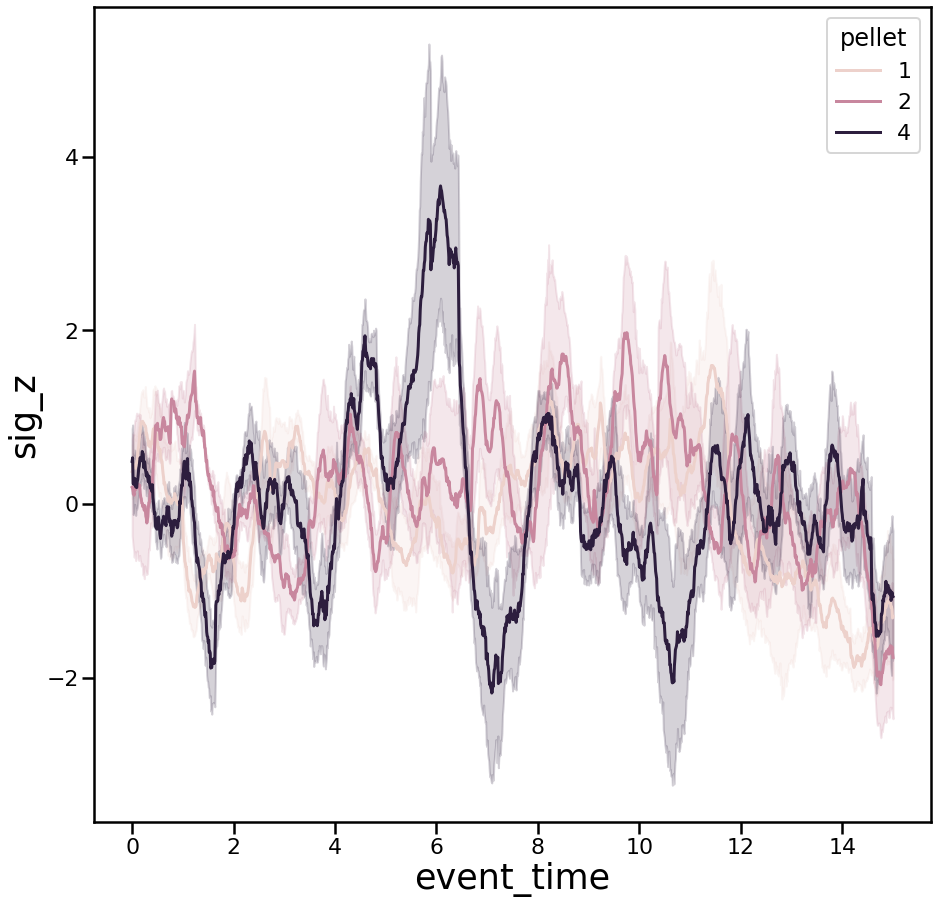

1158


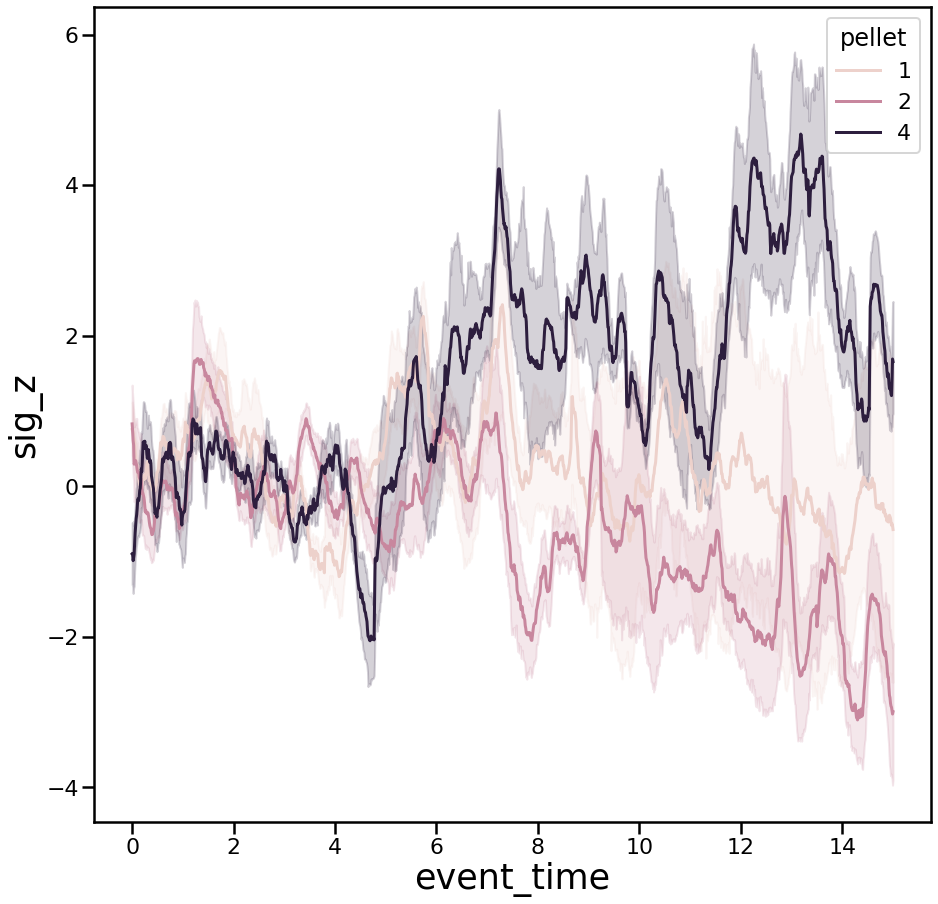

1165


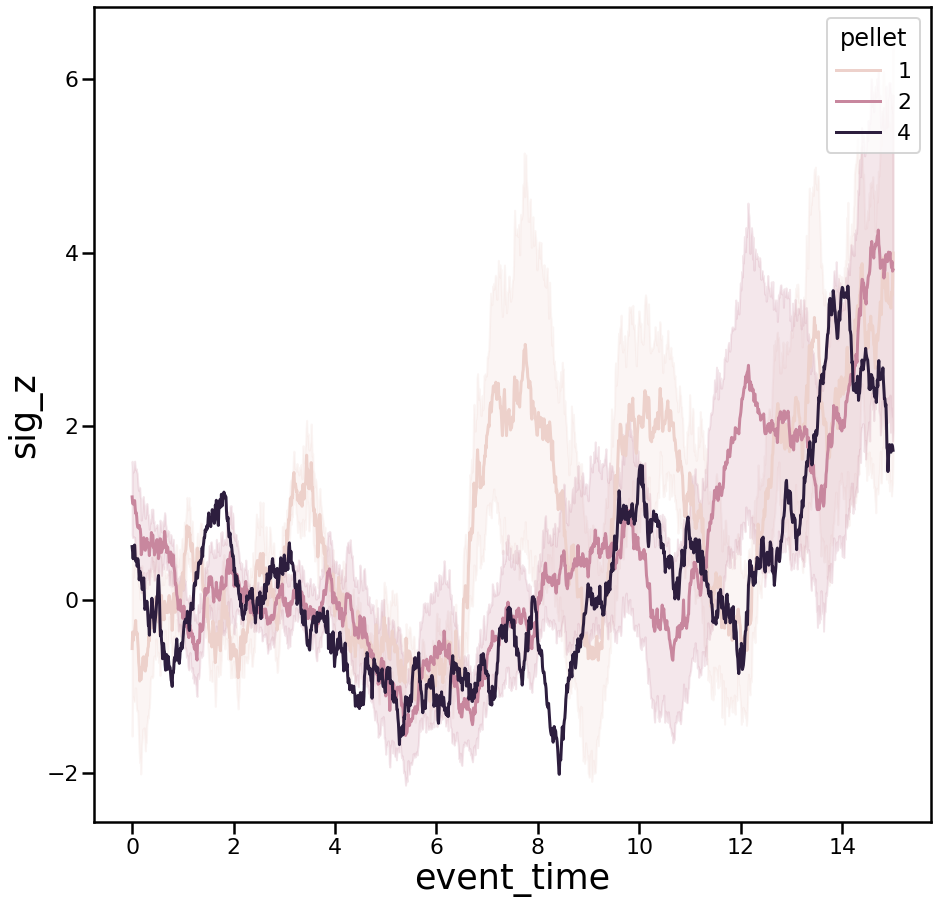

1153


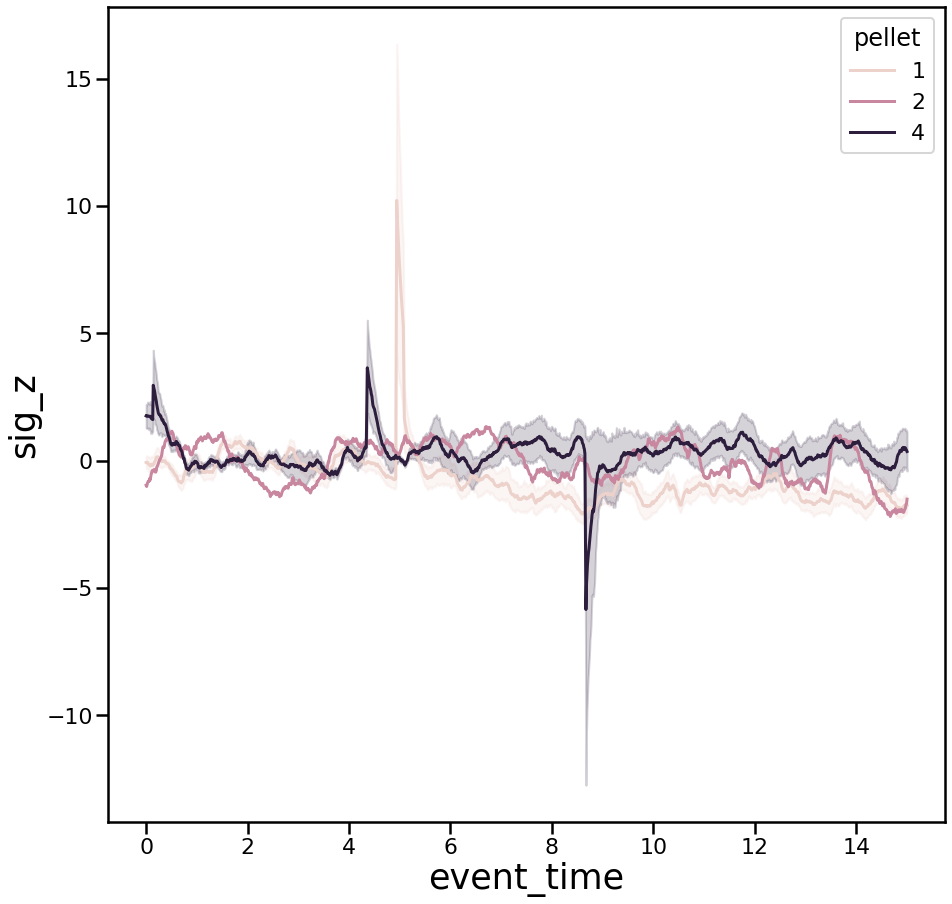

1161


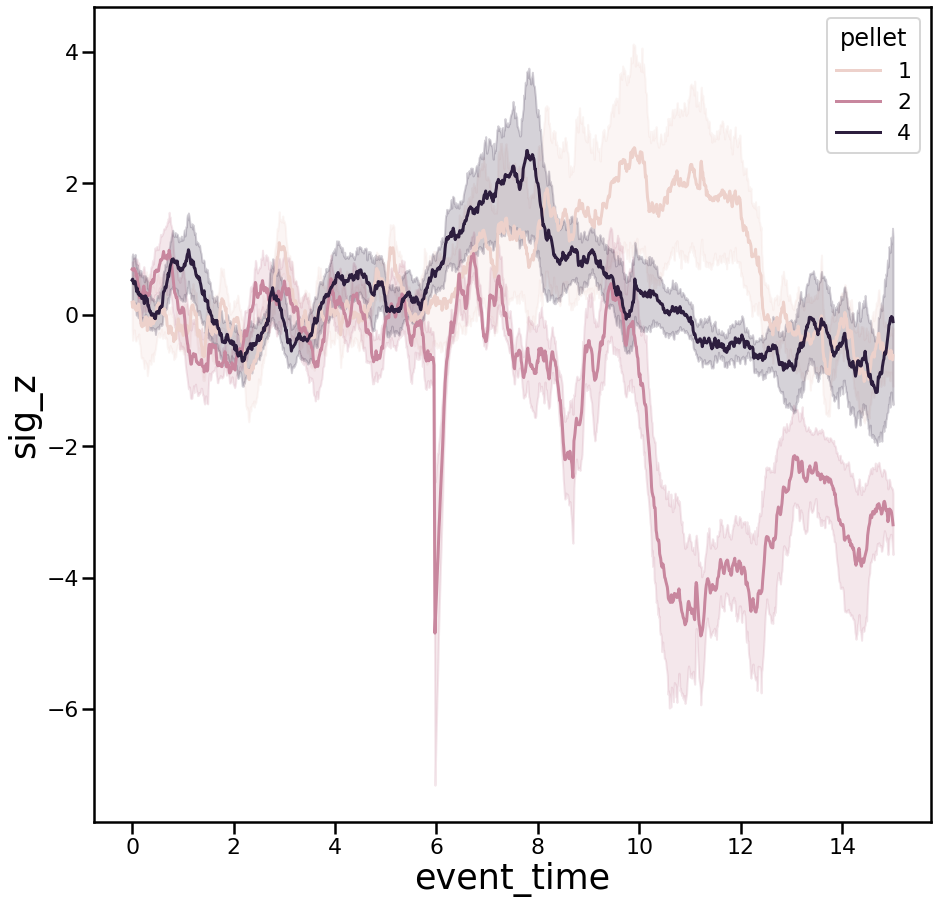

1157


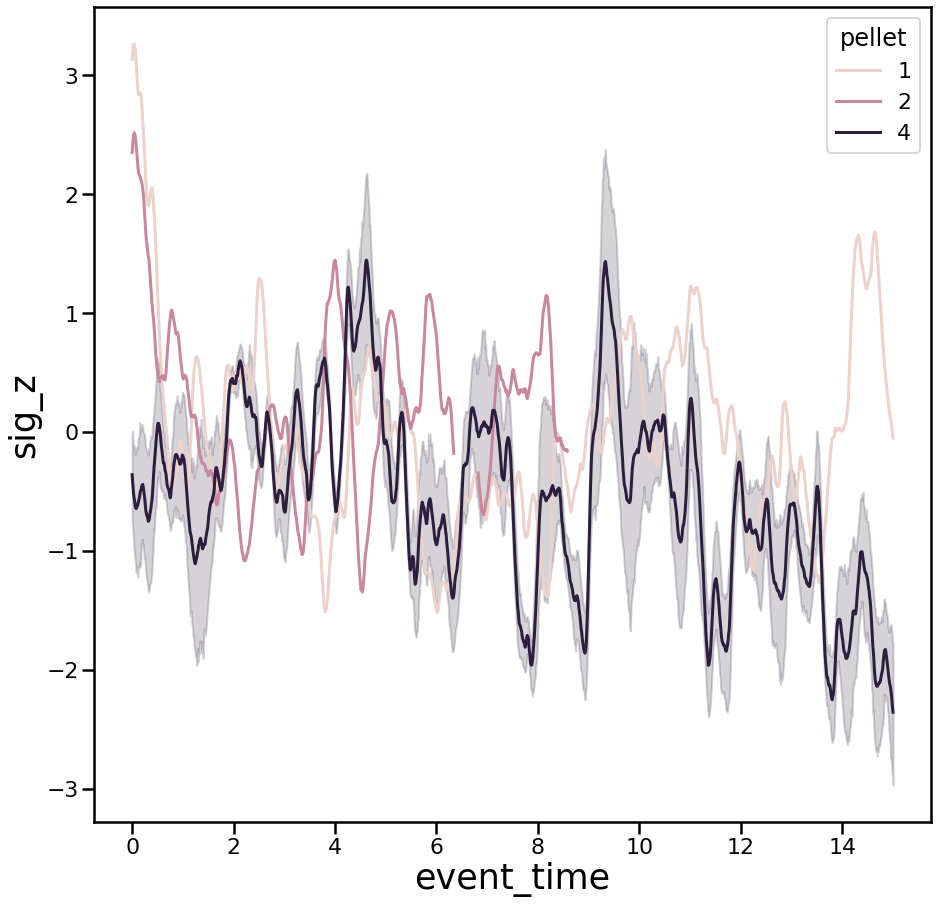

1160


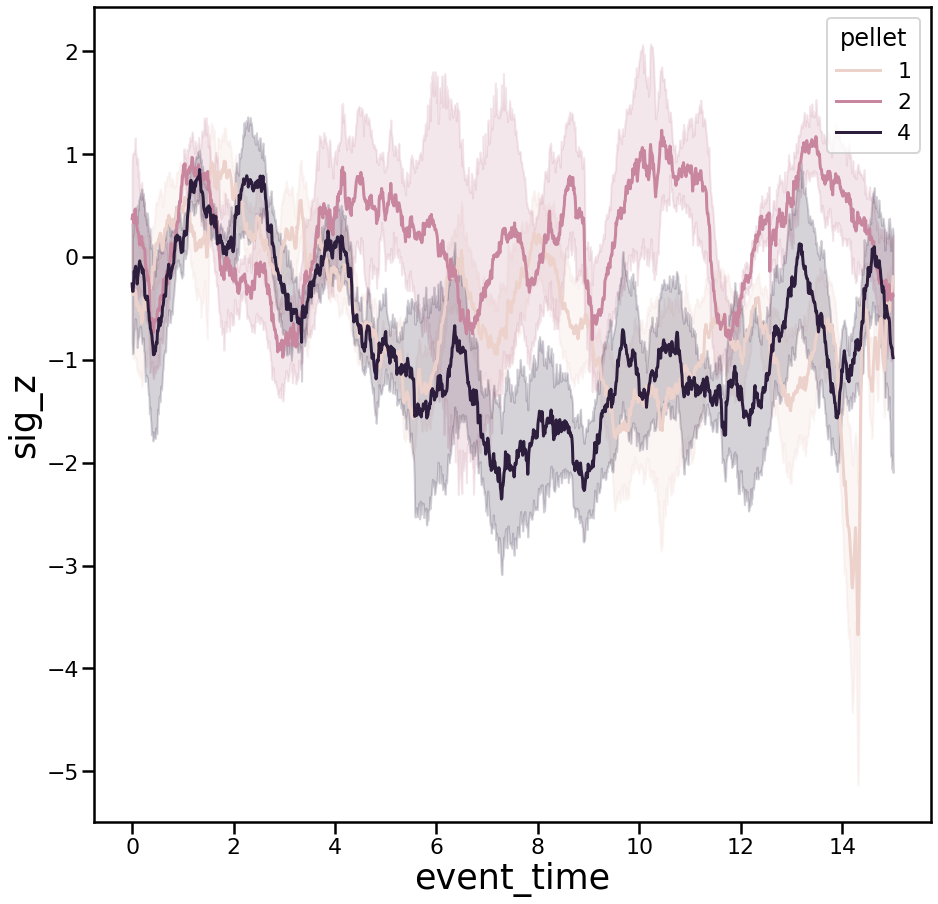

1154


KeyboardInterrupt: 

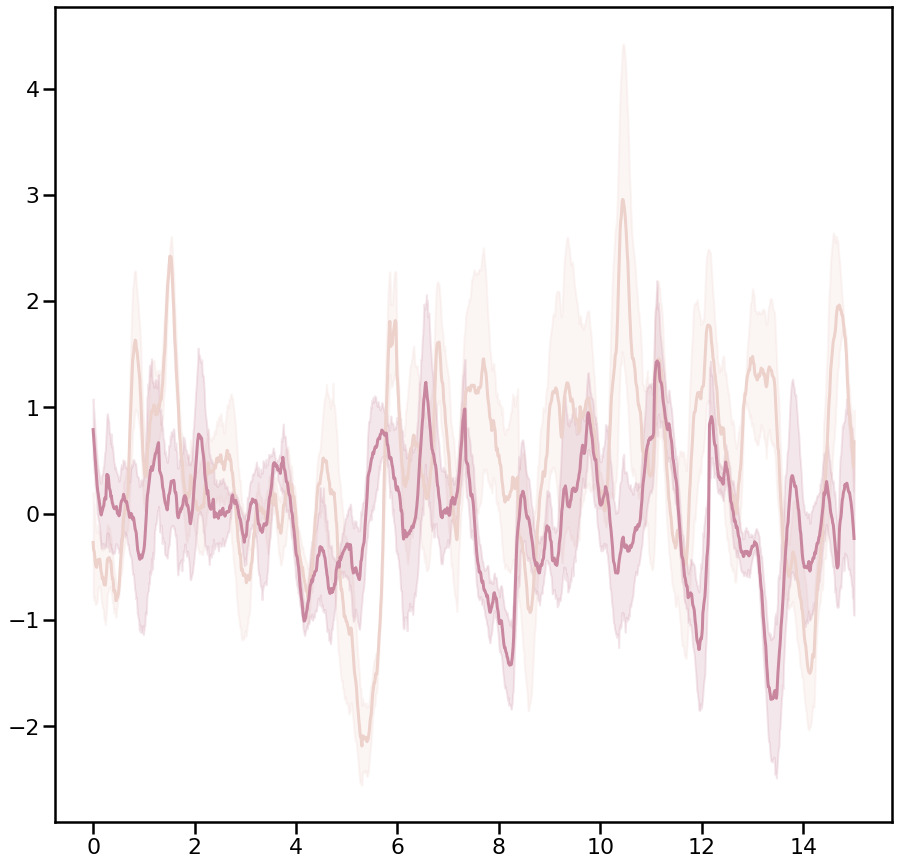

In [81]:
for animal in data_comb['Animal'].unique():
    print(animal)
    plt.figure(figsize=(15,15))
    df_int = perievent_df[perievent_df['Animal'] == animal]
    sns.lineplot(x='event_time', y='sig_z', data=df_int, ci=68, hue='pellet')
    plt.show()

In [ ]:
file_path = file_paths[11]
print('file_path:', '\n', file_path, '\n')

task, session, animal, date = get_file_info(file_path)
print('task:', task, 'date:', date, 'animal:', animal, 'session:', session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E", "T")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_VP(events_and_times, 16, 100)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times)
print(trial_data.head(), '\n')

bit_dic = {'HE': 6, 'pellet': 5}
session_data = create_session_df(trial_data, bit_dic)
session_data